# Example: mesh a delineated watershed

Here we mesh the Coal Creek Watershed, CO as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,yaml
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
# from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import pandas
import datetime
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.land_cover_properties

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


In [3]:
import h5py
from modvis import ATSutils

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS (in UTM coordinates) that is included in the shapefile. 

<span style="color:blue;">If the CRS is in lat-lon (in degrees), convert it to UTM (in meters).</span>


In [4]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_shapefile = '../../data/examples/BSF/sources/shapefile/BSF_USGS_UTM_12.shp'
watershed_landcover = '../../data/examples/BSF/sources/land_cover/NLCD/LC_BSF.tif'

watershed_glhymps = '../../data/examples/BSF/sources/GLHYMPS/GLHYMPS_BSF.shp'
watershed_dtb = '../../data/examples/BSF/sources/DTB/DTB.tif'
watershed_modis_lulc = '../../data/examples/BSF/sources/land_cover/MODIS/MCD12Q1.061_500m_aid0001.nc'
watershed_modis_lai = '../../data/examples/BSF/sources/land_cover/MODIS/MCD15A3H.061_500m_aid0001.nc'

config = {} # this will store all the filenames used in input file
config_fname = '../../data/examples/BSF/processed/config.yaml'

hint = '1601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
huc = "1601020302" # provide the huc code for that watershed. If None, the script will automatically search for the HUC code.
simplify = 30 # length scale to target average edge, same unit as the watershed CRS

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start_date = "2010-10-1"
end_date = "2022-10-1"
# origin of simulation. By default, use the first available date of Daymet forcing. 
# This is necessary to ensure that all datesets use the same origin date.
origin_date = "1980-1-1"

logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)

2023-10-06 21:55:22,398 - root - INFO: 
2023-10-06 21:55:22,399 - root - INFO: Meshing shape: ../../data/examples/BSF/sources/shapefile/BSF_USGS_UTM_12.shp
2023-10-06 21:55:22,400 - root - INFO: ==============================
2023-10-06 21:55:22,401 - root - INFO: 
2023-10-06 21:55:22,401 - root - INFO: Loading shapes
2023-10-06 21:55:22,402 - root - INFO: ------------------------------
2023-10-06 21:55:22,403 - root - INFO: Loading file: '../../data/examples/BSF/sources/shapefile/BSF_USGS_UTM_12.shp'
2023-10-06 21:55:22,463 - root - INFO: ... found 1 shapes
2023-10-06 21:55:22,464 - root - INFO: Converting to shapely


### Sources

A wide range of data sources are available and shown below:

| source | File_Manager | Options|
|:---:|:---:|:---:|
|sources['DEM']| `FileManagerNED()` | `1 arc-second` (*); `1/3 arc-second`|
|sources['HUC']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`; `WBD`|
|sources['hydrography']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`|
|sources['land cover']| `FileManagerNLCD()` | `NLCD (L48)` (*); `NLCD (AK)`; `MODIS`|
|sources['geologic structure']| `FileManagerGLHYMPS()` | `GLHYMPS` (*)|
|sources['soil structure']| `FileManagerNRCS()` | `NRCS SSURGO` (*)|
|sources['DTB']| `FileManagerSoilGrids2017()` | `SoilGrids2017` (*)|
|sources['lai']| `FileManagerMODISAppEEARS()` | `MODIS` (*)|
|sources['meteorology']| `FileManagerDaymet()` | `DayMet` (*)|

Note, custom sources can be imported using:

```python
# if raster
sources['SOURCE NAME'] = watershed_workflow.source_list.FileManagerRaster('PATH/TO/RASTER')

# for example
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('./Global_absoluteDTB_M_250m_ll.tif')
```

By default, Watershed-Workflow (WW) will place all the downloads in a folder named `data_library` or the mounted data volume and has the following structure (generated by WW):

```bash
.
├── dem
│   ├── 13as_raw
│   └── 1as_raw
├── hydrography
├── land_cover
│   ├── MODIS
│   ├── NLCD_2016_Land_Cover_L48
│   └── NLCD_2019_Land_Cover_L48
├── meteorology
│   └── daymet
└── soil_structure
    ├── GLHYMPS
    ├── SSURGO
    ├── SoilGrids2017
    └── depth-to-bedrock
```

Some of the sources do not have API and they need to be downloaded manually. Here are a list of sources to download:

| source | Download Link| Local Path| Notes|
|:---:|:---:|:---:|:---:|
| GLHYMPS v2  | [link](https://doi.org/10.5683/SP2/TTJNIU) | `data/soil_structure/GLHYMPS`| ~2.4 GB. Unzip the .zip file and place all the files under the path|
| Depth-to-bedrock (~2.4 GB) | [Link](http://globalchange.bnu.edu.cn/research/dtb.jsp) | `data/soil_structure/depth-to-bedrock`| ~10 GB. Look for file named `Global_absoluteDTB_M_250m_ll.tif` (250 m resolution). This file is slightly different from the data found in [SoilGrids](https://soilgrids.org/). Why?|

In [5]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
# sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster(watershed_landcover)
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS(watershed_glhymps)
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster(watershed_dtb)
# sources['MODIS LULC'] = watershed_workflow.source_list.FileManagerRaster(watershed_modis_lulc)

watershed_workflow.source_list.log_sources(sources)

2023-10-06 21:55:22,487 - root - INFO: Using sources:
2023-10-06 21:55:22,488 - root - INFO: --------------
2023-10-06 21:55:22,490 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-10-06 21:55:22,491 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-10-06 21:55:22,491 - root - INFO: DEM: National Elevation Dataset (NED)
2023-10-06 21:55:22,492 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-10-06 21:55:22,493 - root - INFO: geologic structure: ../../data/examples/BSF/sources/GLHYMPS/GLHYMPS_BSF.shp
2023-10-06 21:55:22,493 - root - INFO: land cover: raster
2023-10-06 21:55:22,495 - root - INFO: lai: MODIS
2023-10-06 21:55:22,495 - root - INFO: soil thickness: None
2023-10-06 21:55:22,496 - root - INFO: meteorology: DayMet 1km
2023-10-06 21:55:22,497 - root - INFO: depth to bedrock: raster


In [6]:
# immediately put in request for land cover data -- downloading from Appeears
# can take some time as they must synthesize the data 

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [7]:
# find what HUC our shape is in
if huc is None:
    huc = watershed_workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
logging.info("Found watershed in HUC: {}".format(huc))

2023-10-06 21:55:22,533 - root - INFO: Found watershed in HUC: 1601020302


In [8]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior(), crs, crs, properties=True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq', 
                                                prune_by_area_fraction=0.004)
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_rivers=True, cut_intersections=False)

else:
    rivers = list()
    watershed_workflow.split_hucs.simplify(watershed, simplify)



2023-10-06 21:55:22,554 - root - INFO: 
2023-10-06 21:55:22,555 - root - INFO: Loading Hydrography
2023-10-06 21:55:22,556 - root - INFO: ------------------------------
2023-10-06 21:55:22,557 - root - INFO: Loading streams in HUC 1601020302
2023-10-06 21:55:22,558 - root - INFO:          and/or bounds (429014.0500423278, 4589994.87125261, 466557.2906380118, 4633218.102138742)
2023-10-06 21:55:22,628 - root - INFO:   Using Hydrography file "/home/jovyan/workdir/src/chapters/data/hydrography/NHDPlus_H_1601_GDB/NHDPlus_H_1601.gdb"
2023-10-06 21:55:22,629 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/home/jovyan/workdir/src/chapters/data/hydrography/NHDPlus_H_1601_GDB/NHDPlus_H_1601.gdb' layer 'NHDFlowline' for streams in '(429014.0500423278, 4589994.87125261, 466557.2906380118, 4633218.102138742)'
2023-10-06 21:57:42,943 - root - INFO:   Found total of 2353 in bounds.
2023-10-06 21:57:42,954 - root - INFO:   Filtering reaches not in-network
20

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


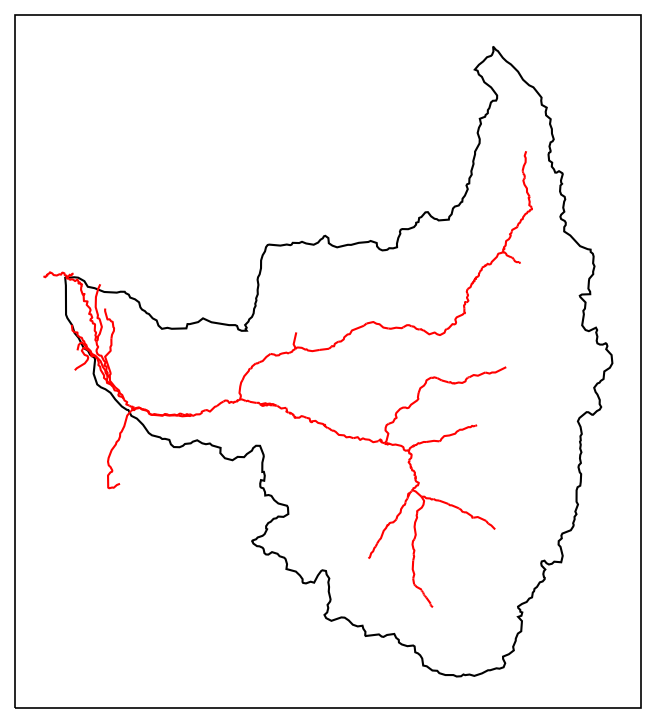

In [9]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

### Meshing

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle centroid to the nearest stream. A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

Adjust distance and area parameters to refine triangles. 

<span style="color:blue;"> Be careful with the min triangular area (e.g., \<1 m^2) in the meshes. It will likely cause the model to run extremely slowly. You may also receive an error saying the tolerance value (i.e., the minimum node distance) is too small.</span> You can increase the smoothing parameter such as `simplify_hucs` or `simplify_rivers` to make the boundaries smoother and meshes coarser.


2023-10-06 21:58:35,765 - root - INFO: 
2023-10-06 21:58:35,767 - root - INFO: Meshing
2023-10-06 21:58:35,768 - root - INFO: ------------------------------
2023-10-06 21:58:35,777 - root - INFO: Triangulating...
2023-10-06 21:58:35,782 - root - INFO:    534 points and 534 facets
2023-10-06 21:58:35,783 - root - INFO:  checking graph consistency
2023-10-06 21:58:35,784 - root - INFO:  tolerance is set to 1
2023-10-06 21:58:35,790 - root - INFO:  building graph data structures
2023-10-06 21:58:35,795 - root - INFO:  triangle.build...
2023-10-06 21:58:48,034 - root - INFO:   ...built: 20803 mesh points and 40858 triangles
2023-10-06 21:58:48,036 - root - INFO: Plotting triangulation diagnostics
2023-10-06 21:58:51,643 - root - INFO:   min area = 1475.9090576171875
2023-10-06 21:58:51,645 - root - INFO:   max area = 49994.058349609375


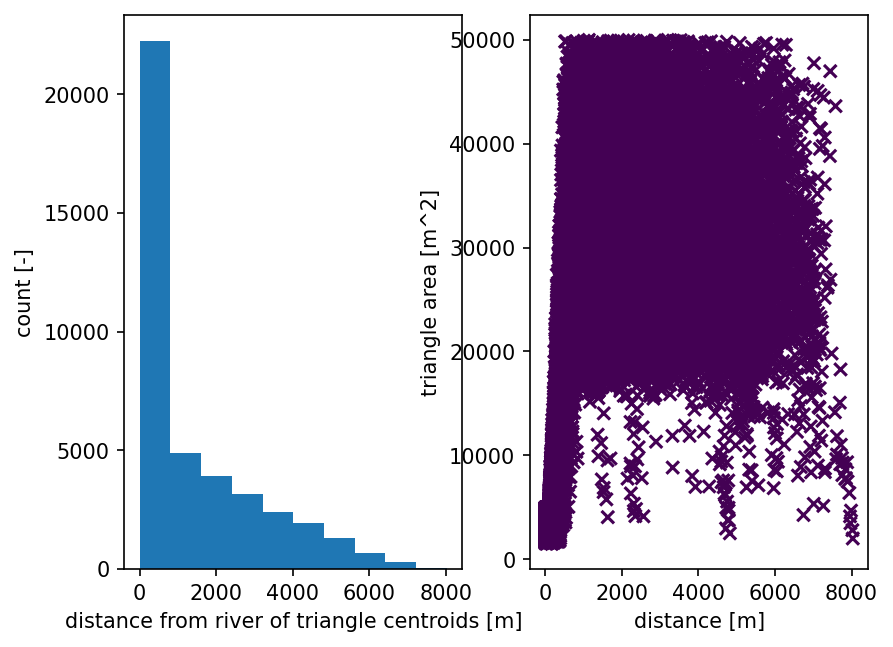

In [10]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500 # distance in meters
A0 = 5000; A1 = 50000 # triangular area in m^2
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [11]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2023-10-06 21:58:52,642 - root - INFO: 
2023-10-06 21:58:52,644 - root - INFO: Loading Raster
2023-10-06 21:58:52,645 - root - INFO: ------------------------------
2023-10-06 21:58:52,646 - root - INFO: Collecting raster
2023-10-06 21:58:52,650 - root - INFO: Collecting DEMs to tile bounds: [-111.86318349411353, 41.45033044502024, -111.39164505002269, 41.85976991316574]
2023-10-06 21:58:52,682 - root - INFO:   Need:
2023-10-06 21:58:52,683 - root - INFO:     /home/jovyan/workdir/src/chapters/data/dem/USGS_NED_1as_n42_w112.tif
2023-10-06 21:58:52,690 - root - INFO: source files already exist!
2023-10-06 21:58:53,030 - root - INFO: ... got raster of shape: (1474, 1698)
2023-10-06 21:58:53,032 - root - INFO: ... got raster bounds: (-111.86318349411353, 41.85976991316574, -111.39151682743119, 41.450325468707696)


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(4580000.0, 0, ''),
 Text(4590000.0, 0, ''),
 Text(4600000.0, 0, ''),
 Text(4610000.0, 0, ''),
 Text(4620000.0, 0, ''),
 Text(4630000.0, 0, ''),
 Text(4640000.0, 0, '')]

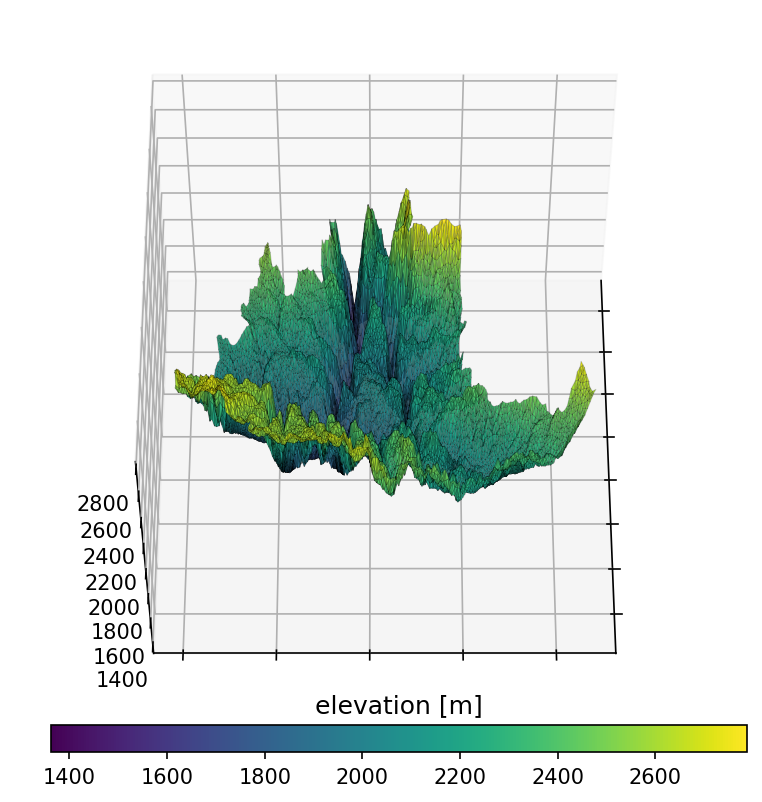

In [12]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = watershed_workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())


(423267.5492801467, 470813.1035327619)
(4587833.7094430635, 4635379.263695679)


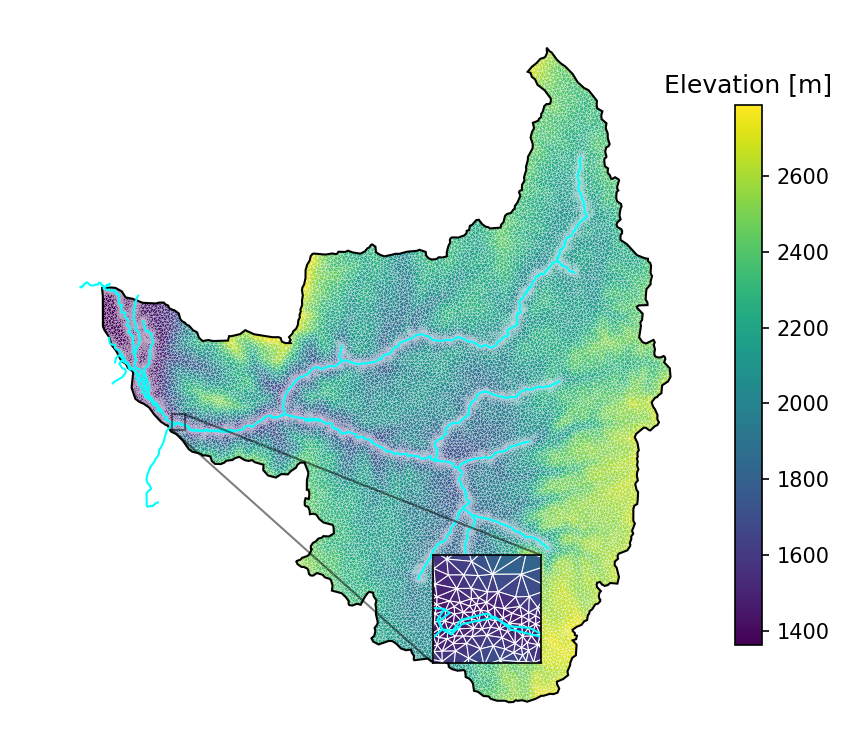

In [13]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.8,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.58,0.10,0.15,0.15])
cbax = fig.add_axes([.85,0.2,0.03,0.6])

xlim = (433633., 434500.)
ylim = (4608000., 4609000.)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.5)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')
ax.indicate_inset_zoom(ax2, edgecolor='k')

# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left", pad=3, frameon=False)
# ax.add_artist(scalebar1)
ax.axis('off')
print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')
fig.savefig('../figures/watershed_mesh-2d.jpg',dpi=300)

In [14]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

Condition the mesh to remove pits and ponds in the meshes. <span style="color:blue;">Advanced tip: use `fill_pits_dual(m2, is_waterbody=waterbody_mask) ` if there exists lakes or reservoirs where pits should not be removed! </span>

max diff =  83.17765850350997


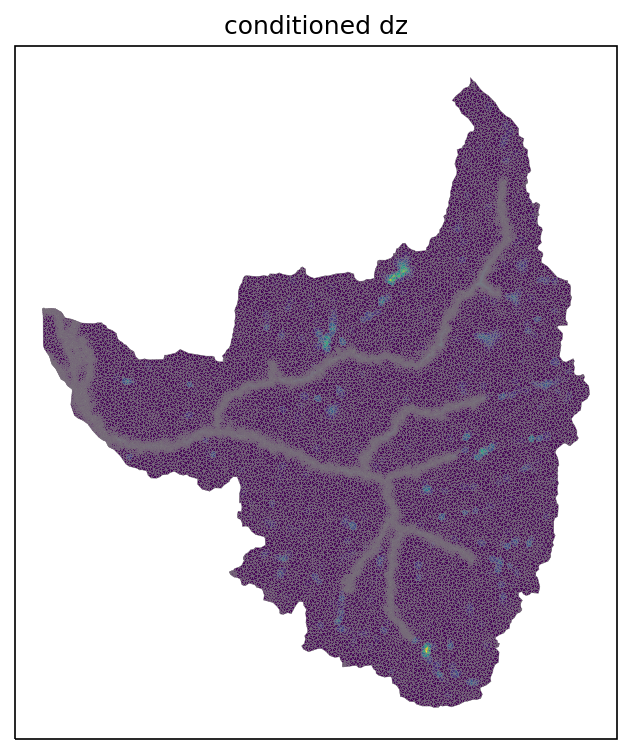

In [15]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Add watershed outlet (optional)

This will add the outlet region in the mesh for better capturing the streamflow in post-processing. Here there is only one catchment with one outlet. However, this may be necessary for watershed with multiple subcatchments with multiple outlets.

In [16]:
list(watershed.polygons())[0].properties

OrderedDict([('TNMID', '{93BEC4A9-0691-4A48-85ED-FECCDC57A695}'),
             ('MetaSource', None),
             ('SourceData', None),
             ('SourceOrig', None),
             ('SourceFeat', None),
             ('LoadDate', '2012-10-24'),
             ('AreaSqKm', 743.32),
             ('AreaAcres', 183677.73),
             ('GNIS_ID', 0),
             ('Name', 'Blacksmith Fork'),
             ('States', 'UT'),
             ('HUC10', '1601020302'),
             ('HUType', 'S'),
             ('HUMod', None),
             ('Shape_Leng', 1.75576306166),
             ('Shape_Area', 0.0803181001675)])

Identify outlets for each catchment. Plot the outlets to verify the correct outlet locations.

Available functions to find the outlets include:
- `find_outlets_by_crossings()`: find all outlets using river network's crossing points on HUC boundary. This may not work well if river has multiple crossings on the same boundary.
- `find_outlets_by_elevation()`: find all outlets by the minimum elevation. This does not work if the minimum elevation within the watershed is not located at the outlet.
- `find_outlets_by_hydroseq()`: find outlets using the HydroSequence VAA of NHDPlus. This may take a while.

In [17]:
watershed_workflow.split_hucs.find_outlets_by_elevation(watershed, crs, dem, dem_profile)

In [18]:
# add labeled sets for subcatcprojectnts and outlets. 
# Here we use HUC12 code, but any other labels would work.
outlet_width = 500  # half-width (unit is the same as in watershed CRS) to track a labeled set on which to get discharge. Use large values to be conservative.
watershed_polygons = list(watershed.polygons())
catchment_labels = [str(p.properties['HUC10']) for p in watershed_polygons]

watershed_workflow.mesh.add_watershed_regions_and_outlets(m2, watershed, 
                                                outlet_width=outlet_width, 
                                               labels=catchment_labels)

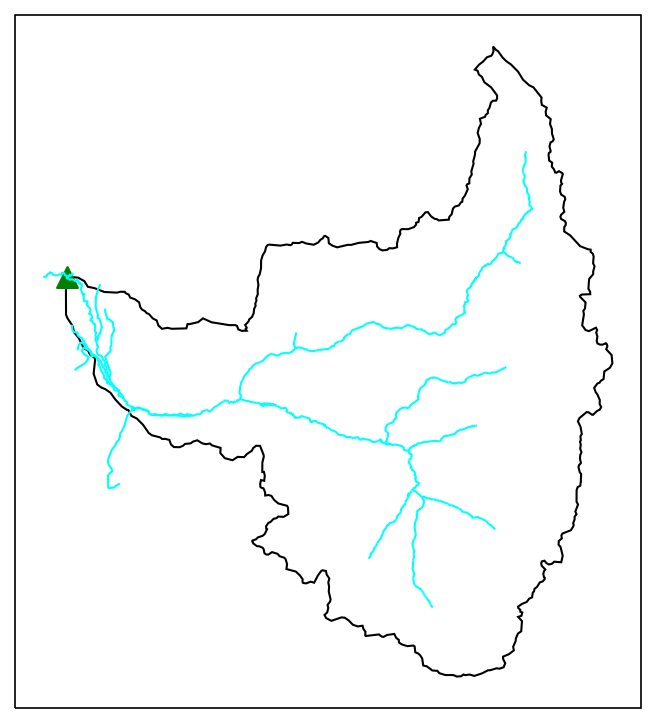

In [19]:
# plot outlets
# fig,ax=plt.subplots(1,1,figsize=(6,4))
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.hucs(watershed, crs, color='k', outlet_marker = '^', ax =ax, linewidth=1)
watershed_workflow.plot.rivers(rivers, crs,  color='aqua', ax =ax, linewidth=1)

In [20]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "1601020302"
10001 : CELL : "1601020302 surface"
10002 : FACE : "1601020302 boundary"
10003 : FACE : "1601020302 outlet"
10004 : FACE : "surface domain outlet"


In [21]:
config['catchment_labels'] = catchment_labels

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

### Land Cover

In [22]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2023-10-06 21:59:07,053 - root - INFO: 
2023-10-06 21:59:07,054 - root - INFO: Loading Raster
2023-10-06 21:59:07,056 - root - INFO: ------------------------------
2023-10-06 21:59:07,058 - root - INFO: Collecting raster
2023-10-06 21:59:07,212 - root - INFO: bounds in my_crs: (-1303968.2141357376, 2155317.8151102653, -1267698.942863916, 2198105.123114599)
2023-10-06 21:59:07,446 - root - INFO: ... got raster of shape: (1427, 1210)
2023-10-06 21:59:07,533 - root - INFO: ... got raster bounds: (-1303995.0, 2198115.0, -1267695.0, 2155305.0)
2023-10-06 21:59:08,141 - root - INFO: Found land cover dtypes: uint8
2023-10-06 21:59:08,144 - root - INFO: Found land cover types: {71, 41, 42, 43, 81, 82, 52, 21, 22, 23, 24, 90, 31, 95}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7ff14ec83a30>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff14ec834c0>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [41 81 42 ... 52 52 52]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

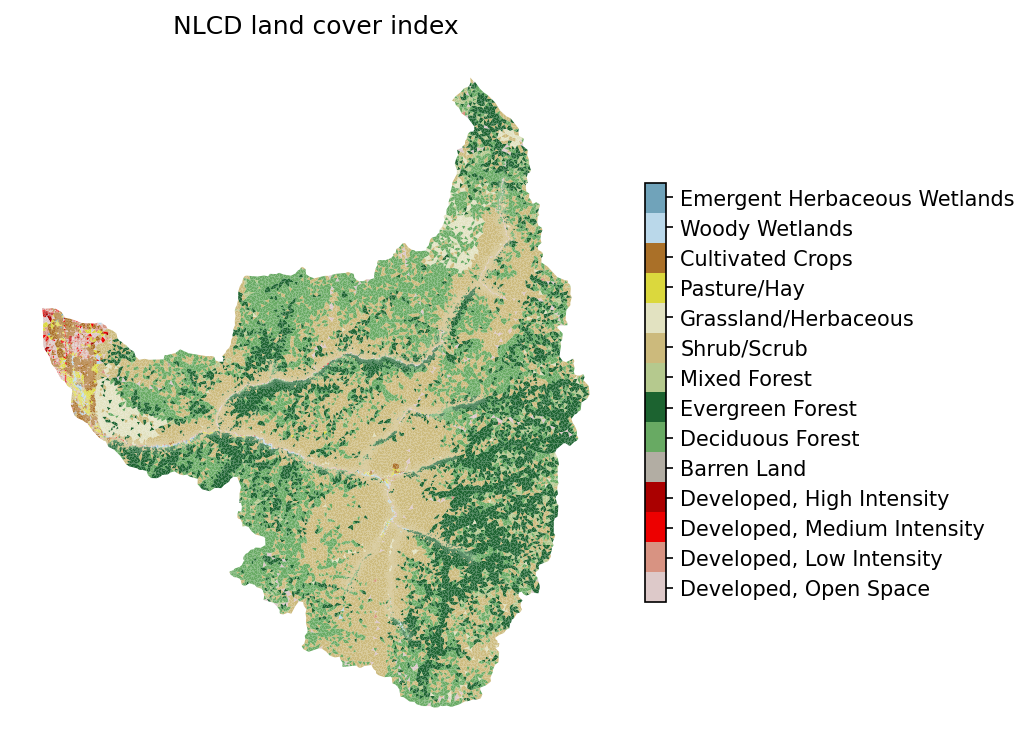

In [23]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels) 
ax.set_title("NLCD land cover index")
ax.axis('off')

In [24]:
nlcd_indices, nlcd_labels

([21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95],
 ['Developed, Open Space',
  'Developed, Low Intensity',
  'Developed, Medium Intensity',
  'Developed, High Intensity',
  'Barren Land',
  'Deciduous Forest',
  'Evergreen Forest',
  'Mixed Forest',
  'Shrub/Scrub',
  'Grassland/Herbaceous',
  'Pasture/Hay',
  'Cultivated Crops',
  'Woody Wetlands',
  'Emergent Herbaceous Wetlands'])

In [25]:
# # add labeled sets to the mesh for NLCD
# nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
# watershed_workflow.mesh.add_nlcd_labeled_sets(m2, lc, nlcd_labels_dict)

# for ls in m2.labeled_sets:
#     print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

### LAI

Download MODIS LAI and LULC, block until it is finished!
NOTE: if you get an error here about MODIS AppEEARs username and password, realize that you must register for a login in the AppEEARs database.  See: `print(sources['lai'].__doc__)`

You may encounter download issues if the files are too big. In that case, manually download the MODIS data using [AppEEARS](https://appeears.earthdatacloud.nasa.gov/). Here are brief steps:

1. Sign in if you already registered. 
2. Click `Extract --> Area`
3. Click `Start a new request`
4. Upload the watershed shapefile (in lat-lon). <span style="color:blue;"> Important: draw a box region surrounding the watershed to avoid downloading no_data! </span>
5. Choose `Start Date` (e.g., 2002-7-1) and `End Date` (e.g., 2021-1-1)
6. Select product for Landcover (e.g., `MCD12Q1.006`) or LAI (e.g., `MCD15A3H.006`)
7. Select layers or for landcover (i.e., `LC_Type1`) or LAI (i.e., `Lai_500m`). You may choose to include all layers, but not all will be used.
8. Select `NetCDF-4` as the output file format 
9. Click `Submit`. It will send an email after download is completed.

In [26]:
# # Uncomment the next three lines if you want to try downloading through WW
# modis = sources['lai'].get_data(watershed.exterior(), crs, start, end)
# if not isinstance(modis, watershed_workflow.datasets.State):
#     modis = sources['lai'].wait(modis)
modis = sources['lai'].get_data(watershed.exterior(), crs, variables = ['LULC', 'LAI'], filenames=[watershed_modis_lulc, watershed_modis_lai])

2023-10-06 21:59:16,235 - root - INFO: ... reading LULC from ../../data/examples/BSF/sources/land_cover/MODIS/MCD12Q1.061_500m_aid0001.nc
2023-10-06 21:59:16,332 - root - INFO: ... reading LAI from ../../data/examples/BSF/sources/land_cover/MODIS/MCD15A3H.061_500m_aid0001.nc


In [27]:
modis['LULC'].times

array([datetime.date(2007, 1, 1), datetime.date(2008, 1, 1),
       datetime.date(2009, 1, 1), datetime.date(2010, 1, 1),
       datetime.date(2011, 1, 1), datetime.date(2012, 1, 1),
       datetime.date(2013, 1, 1), datetime.date(2014, 1, 1),
       datetime.date(2015, 1, 1), datetime.date(2016, 1, 1),
       datetime.date(2017, 1, 1), datetime.date(2018, 1, 1),
       datetime.date(2019, 1, 1), datetime.date(2020, 1, 1),
       datetime.date(2021, 1, 1)], dtype=object)

In [28]:
# select the year of 2016 for MODIS landcover to match 2016 NLCD land cover
lc_idx = np.where(modis['LULC'].times == datetime.date(2016, 1, 1))[0][0]
lc_idx

9

In [29]:
# resample the raster to the triangles
modis_lc = watershed_workflow.values_from_raster(m2.centroids, crs, modis['LULC'].data[lc_idx,:,:], 
                                                 modis['LULC'].profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
logging.info('Found land cover types: {}'.format(set(modis_lc)))

2023-10-06 21:59:17,077 - root - INFO: Found land cover dtypes: int16
2023-10-06 21:59:17,082 - root - INFO: Found land cover types: {1, 4, 5, 8, 9, 10, 12, 13, -1}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7ff14d36b010>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff14d36a6b0>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [10 12 10 ... 10 10 10]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

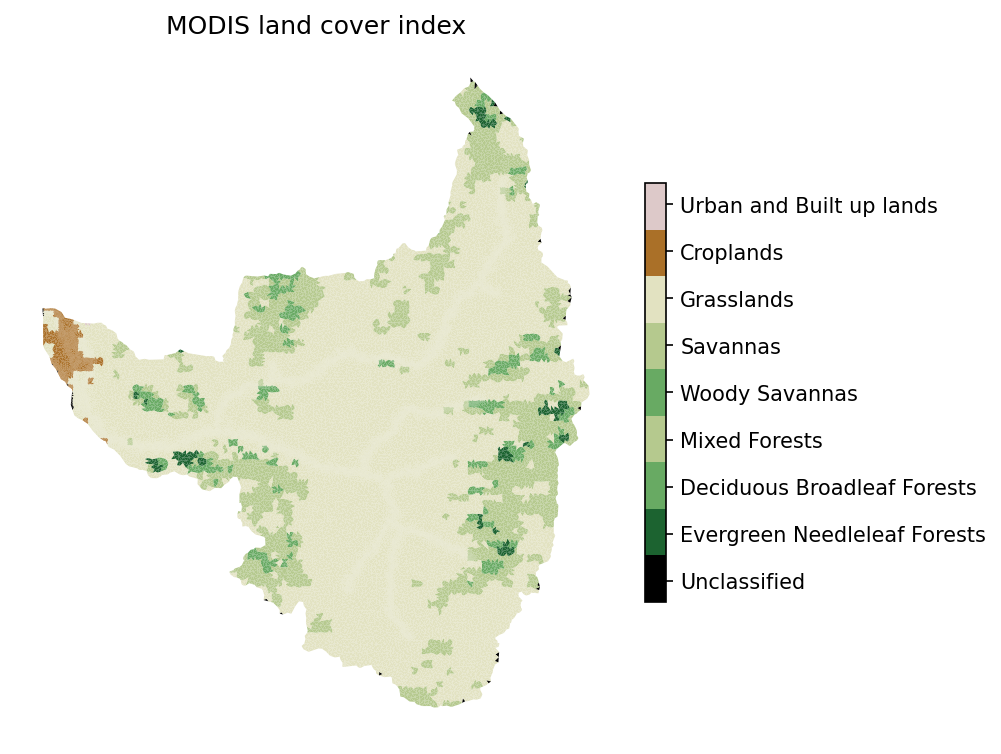

In [30]:
# plot the modis lulc data

# -- get the MODIS colormap which uses official MODIS colors and labels
modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(modis_lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=modis_lc, cmap=modis_cmap, 
                                     norm=modis_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(modis_indices), cmap=modis_cmap, 
                                         labels=modis_labels) 
ax.set_title("MODIS land cover index")
ax.axis('off')

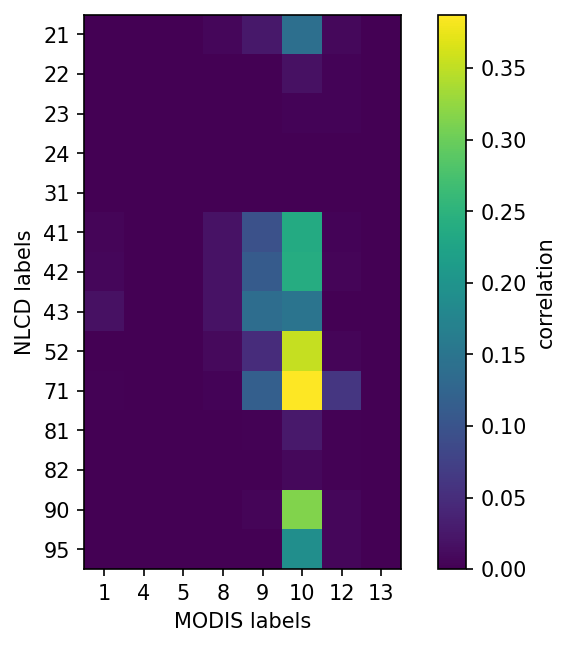

In [31]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best.  
unique_nlcd = list(np.unique(lc))
unique_modis = modis_indices

crosswalk = watershed_workflow.land_cover_properties.compute_crosswalk_correlation(
    modis['LULC'].profile, modis['LULC'].data[lc_idx,:,:], lc_profile, lc_raster, unique_nlcd = unique_nlcd, unique_modis=unique_modis)

In [32]:
# print the crosswalk.
crosswalk

{21: 10,
 22: 10,
 23: 10,
 24: 12,
 31: 1,
 41: 10,
 42: 10,
 43: 10,
 52: 10,
 71: 10,
 81: 10,
 82: 10,
 90: 10,
 95: 10}

In [33]:
nlcd_color_new = 99 * np.ones_like(lc)

for k,v in crosswalk.items():
    # for label in v:
    # index = sources['land cover'].indices[label]
    nlcd_color_new[np.where(lc == k)] = v

In [34]:
np.unique(nlcd_color_new)

array([ 1, 10, 12], dtype=uint8)

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7ff14d21f490>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff14d21e650>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [10 10 10 ... 10 10 10]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

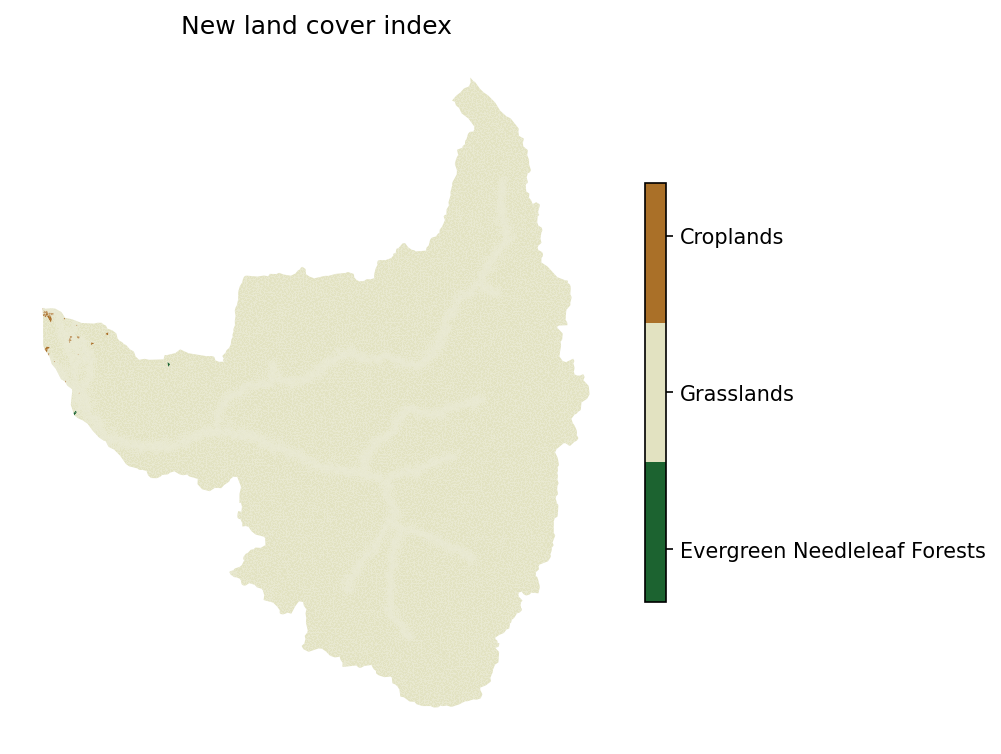

In [35]:
# plot new NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices_new, nlcd_cmap_new, nlcd_norm_new, nlcd_ticks_new, nlcd_labels_new = \
                watershed_workflow.colors.generate_modis_colormap(nlcd_color_new)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new, cmap=nlcd_cmap_new, 
                                     norm=nlcd_norm_new, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices_new), cmap=nlcd_cmap_new, 
                                         labels=nlcd_labels_new) 
ax.set_title("New land cover index")
ax.axis('off')

In [36]:
nlcd_indices_new, nlcd_labels_new

([1, 10, 12], ['Evergreen Needleleaf Forests', 'Grasslands', 'Croplands'])

In [37]:
# add labeled sets to the mesh for new NLCD
nlcd_labels_new = ['MODIS ' + i for i in nlcd_labels_new]
nlcd_labels_dict = dict(zip(nlcd_indices_new, nlcd_labels_new))
watershed_workflow.mesh.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)

In [38]:
config['nlcd_indices'] = [int(i) for i in nlcd_indices_new]
config['nlcd_labels'] = nlcd_labels_new

In [39]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "1601020302"
10001 : CELL : "1601020302 surface"
10002 : FACE : "1601020302 boundary"
10003 : FACE : "1601020302 outlet"
10004 : FACE : "surface domain outlet"
1 : CELL : "MODIS Evergreen Needleleaf Forests"
10 : CELL : "MODIS Grasslands"
12 : CELL : "MODIS Croplands"


In [40]:
# compute area averaged LAI for each modis land cover
lai_time_series = watershed_workflow.land_cover_properties.compute_time_series(
modis['LAI'], modis['LULC'], unique_lc = unique_modis, lc_idx = lc_idx)
lai_time_series

time [datetime]  MODIS Evergreen Needleleaf Forests LAI [-]  \
0         2007-06-30                                    2.242593   
1         2007-07-04                                    1.827778   
2         2007-07-08                                    2.344444   
3         2007-07-12                                    2.111111   
4         2007-07-16                                    2.100000   
...              ...                                         ...   
1237      2020-12-18                                    0.290741   
1238      2020-12-22                                    0.379630   
1239      2020-12-26                                    0.835185   
1240      2020-12-30                                    0.442593   
1241      2021-01-01                                    0.442593   

      MODIS Deciduous Broadleaf Forests LAI [-]  MODIS Mixed Forests LAI [-]  \
0                                      4.583333                        3.975   
1                                      2.700000                        2.700   
2                                      3.366667                        2.825   
3                                      4.000000                        3.050   
4                                      3.900000                        3.375   
...                                         ...                          ...   
1237                                   0.116667                        0.125   
1238                                   0.150000                        0.200   
1239                                   0.266667                        0.250   
1240                                   0.100000                        0.150   
1241                                   0.100000                        0.175   

      MODIS Woody Savannas LAI [-]  MODIS Savannas LAI [-]  \
0                         2.505914                2.019174   
1                         2.095161                1.842281   
2                         2.240323                1.876991   
3                         2.286022                1.944739   
4                         2.237097                1.770305   
...                            ...                     ...   
1237                      0.387097                0.250639   
1238                      0.226882                0.233137   
1239                      0.225806                0.180236   
1240                      0.479032                0.224385   
1241                      0.475806                0.229105   

      MODIS Grasslands LAI [-]  MODIS Croplands LAI [-]  \
0                     1.359011                 1.565714   
1                     1.290311                 1.218571   
2                     1.287458                 1.574286   
3                     1.281441                 1.228571   
4                     1.170734                 1.255714   
...                        ...                      ...   
1237                  0.178898                 0.044286   
1238                  0.200282                 0.097143   
1239                  0.144068                 0.072857   
1240                  0.177768                 0.067143   
1241                  0.174746                 0.085714   

      MODIS Urban and Built up lands LAI [-]  
0                                        NaN  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                        NaN  
...                                      ...  
1237                                     NaN  
1238                                     NaN  
1239                                     NaN  
1240                                     NaN  
1241                                     NaN  

[1242 rows x 9 columns]

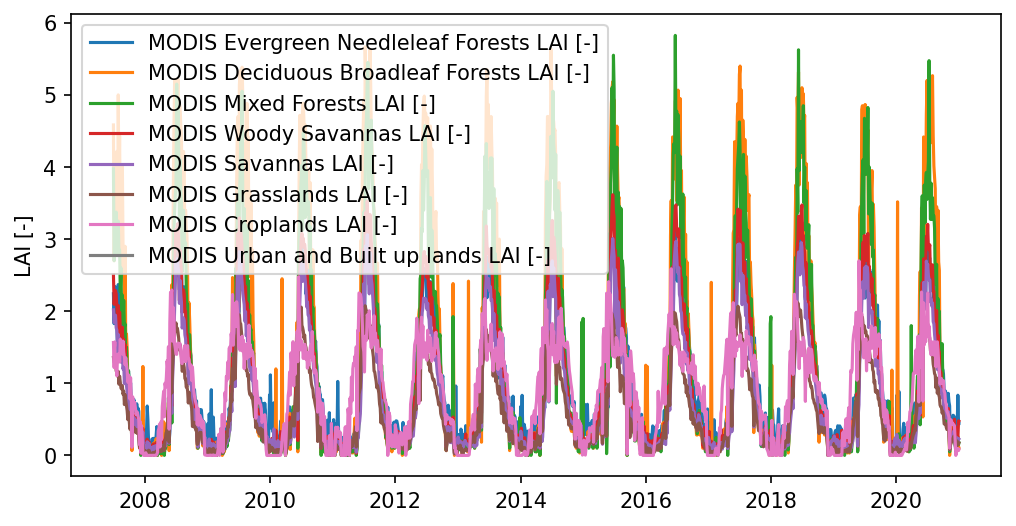

In [41]:
# plot LAI
fig,ax = plt.subplots(1,1, figsize=(8,4))
times = pandas.to_datetime(lai_time_series['time [datetime]'])
for icol in lai_time_series.columns[1:]:
    ax.plot(times, lai_time_series[icol], label = icol)
plt.ylabel("LAI [-]")
ax.legend()

In [42]:
# write raw LAI to disk
config['LAI_filename'] = os.path.join('..', '..', 'data', 'examples', 'BSF', 'processed', 'watershed_lai_raw.h5')
watershed_workflow.io.write_timeseries_to_hdf5(config['LAI_filename'], lai_time_series, 
                                              attributes={'name': 'MODIS LAI based on MODIS LULC',
                                                         'unit': 'none'}, time0=origin_date)                                            

2023-10-06 21:59:48,050 - root - INFO: Writing HDF5 file: ../../data/examples/BSF/processed/watershed_lai_raw.h5


Generate smoothed MODIS LAI data for spinup runs.

In [43]:
# compute area averaged LAI for each modis land cover
lai_time_series_smoothed = watershed_workflow.land_cover_properties.compute_time_series(
modis['LAI'], modis['LULC'], unique_lc = unique_modis, lc_idx = lc_idx, smooth=True)
lai_time_series_smoothed

time [datetime]  MODIS Evergreen Needleleaf Forests LAI [-]  \
0         2007-06-30                                    2.057156   
1         2007-07-01                                    2.057752   
2         2007-07-02                                    2.058326   
3         2007-07-03                                    2.058870   
4         2007-07-04                                    2.059375   
...              ...                                         ...   
4930      2020-12-28                                    0.500681   
4931      2020-12-29                                    0.516687   
4932      2020-12-30                                    0.533603   
4933      2020-12-31                                    0.551444   
4934      2021-01-01                                    0.570221   

      MODIS Deciduous Broadleaf Forests LAI [-]  MODIS Mixed Forests LAI [-]  \
0                                      3.241771                     3.158054   
1                                      3.308082                     3.161133   
2                                      3.370917                     3.163021   
3                                      3.430322                     3.163740   
4                                      3.486346                     3.163308   
...                                         ...                          ...   
4930                                   0.147911                     0.166308   
4931                                   0.139909                     0.161812   
4932                                   0.131342                     0.156915   
4933                                   0.122191                     0.151600   
4934                                   0.112436                     0.145849   

      MODIS Woody Savannas LAI [-]  MODIS Savannas LAI [-]  \
0                         2.350726                1.996013   
1                         2.335052                1.979769   
2                         2.319520                1.963722   
3                         2.304124                1.947866   
4                         2.288859                1.932197   
...                            ...                     ...   
4930                      0.355481                0.216564   
4931                      0.364552                0.220174   
4932                      0.374034                0.224060   
4933                      0.383929                0.228226   
4934                      0.394240                0.232672   

      MODIS Grasslands LAI [-]  MODIS Croplands LAI [-]  \
0                     1.352426                 1.353209   
1                     1.342191                 1.350092   
2                     1.332085                 1.347385   
3                     1.322104                 1.345074   
4                     1.312243                 1.343145   
...                        ...                      ...   
4930                  0.170874                 0.039425   
4931                  0.170976                 0.025544   
4932                  0.171129                 0.011318   
4933                  0.171331                -0.003262   
4934                  0.171582                -0.018206   

      MODIS Urban and Built up lands LAI [-]  
0                                        NaN  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                        NaN  
...                                      ...  
4930                                     NaN  
4931                                     NaN  
4932                                     NaN  
4933                                     NaN  
4934                                     NaN  

[4935 rows x 9 columns]

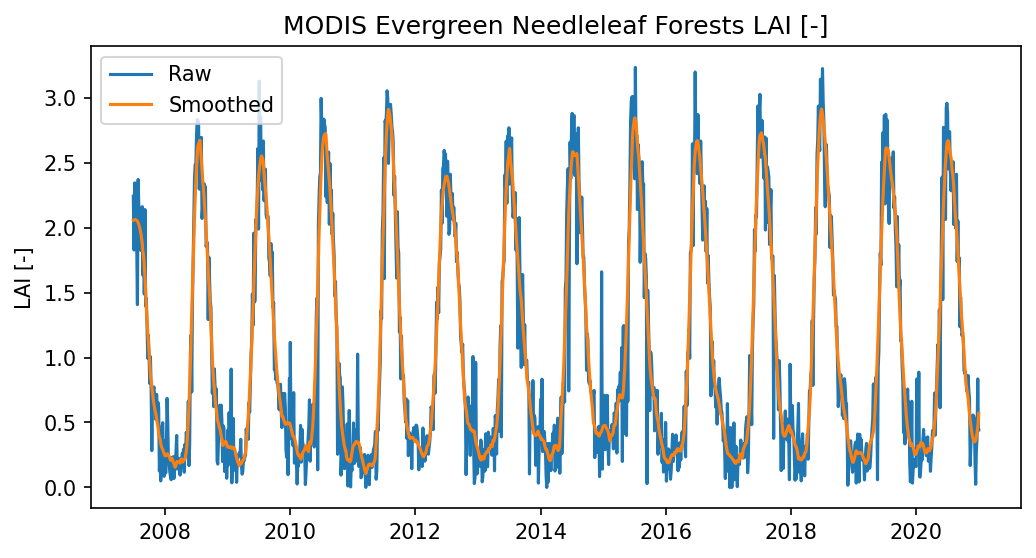

In [44]:
# plot LAI
ilc = lai_time_series.columns[1]
fig,ax = plt.subplots(1,1, figsize=(8,4))
times = pandas.to_datetime(lai_time_series['time [datetime]'])
new_times = pandas.to_datetime(lai_time_series_smoothed['time [datetime]'])

ax.plot(times, lai_time_series[ilc], label = "Raw")
ax.plot(new_times, lai_time_series_smoothed[ilc], label = "Smoothed")
plt.ylabel("LAI [-]")
plt.title(ilc)
ax.legend()

In [45]:
lai_time_series_smoothed["time [datetime]"] = pandas.to_datetime(lai_time_series_smoothed["time [datetime]"])
lai_time_series_smoothed.set_index("time [datetime]", inplace=True)

<AxesSubplot:xlabel='time [datetime],time [datetime]'>

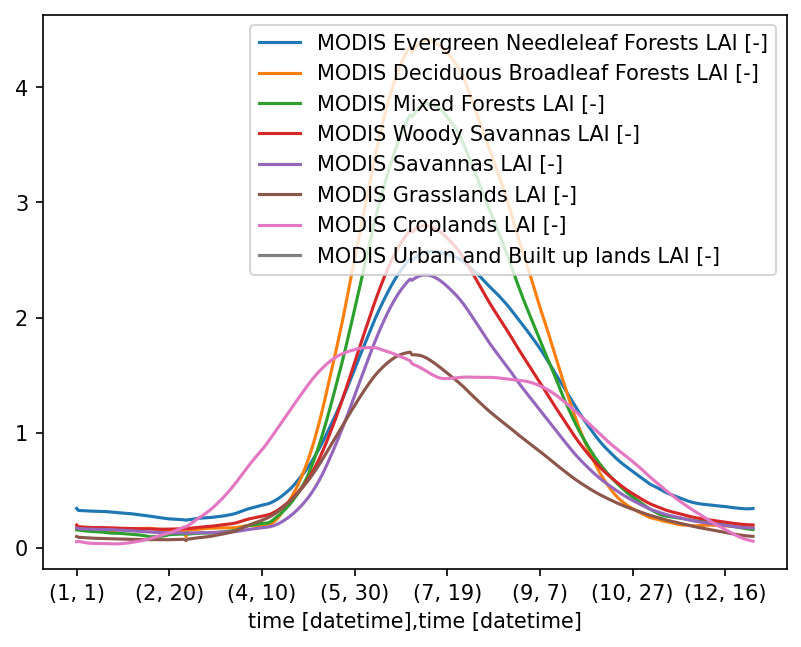

In [46]:
lai_avg=lai_time_series_smoothed.groupby([lai_time_series_smoothed.index.month, lai_time_series_smoothed.index.day]).mean()
lai_avg.plot()

In [47]:
# repeat for 40 years
lai_typical = pandas.DataFrame(np.tile(lai_avg.values[:-1,:], (40, 1)), columns=lai_avg.columns)
lai_typical['time [s]'] = ATSutils.sec_noleap().iloc[:lai_typical.shape[0], ].values
lai_typical

MODIS Evergreen Needleleaf Forests LAI [-]  \
0                                        0.341289   
1                                        0.323372   
2                                        0.322912   
3                                        0.322240   
4                                        0.321370   
...                                           ...   
14595                                    0.338859   
14596                                    0.337963   
14597                                    0.337711   
14598                                    0.338088   
14599                                    0.339102   

       MODIS Deciduous Broadleaf Forests LAI [-]  MODIS Mixed Forests LAI [-]  \
0                                       0.174076                     0.154950   
1                                       0.178243                     0.153408   
2                                       0.177618                     0.151094   
3                                       0.176813                     0.148940   
4                                       0.175831                     0.146972   
...                                          ...                          ...   
14595                                   0.180003                     0.168688   
14596                                   0.179149                     0.165942   
14597                                   0.178254                     0.163476   
14598                                   0.177315                     0.161307   
14599                                   0.176325                     0.159364   

       MODIS Woody Savannas LAI [-]  MODIS Savannas LAI [-]  \
0                          0.197253                0.170440   
1                          0.181297                0.165113   
2                          0.180639                0.164666   
3                          0.179827                0.164135   
4                          0.178872                0.163511   
...                             ...                     ...   
14595                      0.201783                0.174777   
14596                      0.200484                0.173595   
14597                      0.199378                0.172596   
14598                      0.198470                0.171781   
14599                      0.197833                0.171187   

       MODIS Grasslands LAI [-]  MODIS Croplands LAI [-]  \
0                      0.097226                 0.052021   
1                      0.090418                 0.054457   
2                      0.089391                 0.051580   
3                      0.088335                 0.048800   
4                      0.087237                 0.046093   
...                         ...                      ...   
14595                  0.105608                 0.079032   
14596                  0.103745                 0.073675   
14597                  0.102092                 0.068722   
14598                  0.100652                 0.064149   
14599                  0.099429                 0.060018   

       MODIS Urban and Built up lands LAI [-]    time [s]  
0                                         NaN           0  
1                                         NaN       86400  
2                                         NaN      172800  
3                                         NaN      259200  
4                                         NaN      345600  
...                                       ...         ...  
14595                                     NaN  1261008000  
14596                                     NaN  1261094400  
14597                                     NaN  1261180800  
14598                                     NaN  1261267200  
14599                                     NaN  1261353600  

[14600 rows x 9 columns]

In [48]:
# write to disk
config['LAI_typical_filename'] = os.path.join('..', '..', 'data', 'examples', 'BSF', 'processed', 'watershed_lai_typical.h5')
attributes={'name':f'Typical LAI generated MODIS LAI data from {times[0]} to {times[len(times)-1]}, averaged for all days across each year, then repeated for 40 years',
           'origin date':origin_date}

with h5py.File(config['LAI_typical_filename'],'w') as fid:
    for k in lai_typical:
        fid.create_dataset(k, data=lai_typical[k][:])
    for key, val in attributes.items():
        fid.attrs[key] = val

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [49]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [watershed.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



soil_color = soil_color.astype(int)

2023-10-06 21:59:49,865 - root - INFO: 
2023-10-06 21:59:49,867 - root - INFO: Loading shapes
2023-10-06 21:59:49,868 - root - INFO: ------------------------------
2023-10-06 21:59:49,916 - root - INFO: Attempting to download source for target '/home/jovyan/workdir/src/chapters/data/soil_structure/SSURGO/SSURGO_-111.8552_41.4583_-111.4003_41.8503.shp'
2023-10-06 21:59:52,422 - root - INFO:   Found 1684 shapes.
2023-10-06 21:59:52,424 - root - INFO:   and crs: epsg:4326
2023-10-06 21:59:52,426 - root - INFO:   Downloaded 1684 total shapes
2023-10-06 21:59:52,428 - root - INFO:   Downloaded 192 unique mukeys
2023-10-06 21:59:53,110 - root - INFO: found 192 unique MUKEYs.
2023-10-06 22:00:07,834 - root - INFO: Running Rosetta for van Genutchen parameters
2023-10-06 22:00:08,117 - root - INFO:   ... done
2023-10-06 22:00:08,122 - root - INFO:   requested 183 values
2023-10-06 22:00:08,124 - root - INFO:   got 183 responses
2023-10-06 22:00:08,142 - root - INFO: ... found 192 shapes
2023-10

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ff14d2867d0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff14d2877c0>}
setting face color =  [ 482762  482805 2822436 ...  482719  482661  482661]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

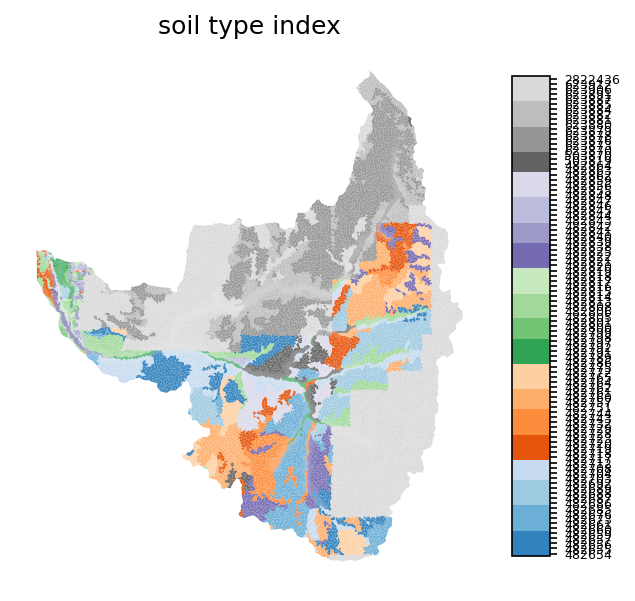

In [50]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')

In [51]:
# Note this is not just the soil ID, but also soil properties.  
# print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)
# only select soils within the watershed
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]
soil_survey_props

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                    
482654                  0.213599              0.478918   
482655                  0.213599              0.478918   
482656                  0.211122              0.465794   
482657                  0.214024              0.463784   
482659                  0.219843              0.485019   
...                          ...                   ...   
623887                  0.221133              0.398932   
623891                  0.200686              0.377417   
623906                  0.186683              0.388543   
623912                  0.256677              0.444627   
2822436                      NaN                   NaN   

         van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                       
482654                      0.000046             1.441284   
482655                      0.000046             1.441284   
482656                      0.000048             1.444267   
482657                      0.000046             1.446796   
482659                      0.000045             1.430216   
...                              ...                  ...   
623887                      0.000072             1.401152   
623891                      0.000123             1.401760   
623906                      0.000161             1.464676   
623912                      0.000094             1.310601   
2822436                          NaN                  NaN   

         Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
mukey                                                                     
482654                 4.039179e-13       56.000000        2.906677e-13   
482655                 4.039179e-13       56.000000        2.906677e-13   
482656                 3.734470e-13       76.210526        3.702062e-13   
482657                 3.341112e-13       71.944444        3.516589e-13   
482659                 3.685584e-13       84.800000        2.792301e-13   
...                             ...             ...                 ...   
623887                 1.527463e-13      152.000000        1.366375e-13   
623891                 2.253589e-13      160.529412        1.640558e-12   
623906                 4.614042e-13      152.000000        1.245940e-13   
623912                 1.515494e-13      152.000000        1.719068e-13   
2822436                         NaN             NaN                 NaN   

         porosity [-]  bulk density [g/cm^3]  total sand pct [%]  \
mukey                                                              
482654       0.292174               1.172609           21.878261   
482655       0.292174               1.172609           21.878261   
482656       0.295844               1.198306           25.583253   
482657       0.278124               1.216497           22.499893   
482659       0.353101               1.179523           18.201691   
...               ...                    ...                 ...   
623887       0.456170               1.432206           38.265160   
623891       0.423943               1.515425           56.060299   
623906       0.440352               1.482500           68.025000   
623912       0.456277               1.397763           35.892105   
2822436           NaN                    NaN                 NaN   

         total silt pct [%]  total clay pct [%] source  
mukey                                                   
482654            50.447826           27.673913   NRCS  
482655            50.447826           27.673913   NRCS  
482656            48.923492           25.493255   NRCS  
482657            51.397380           26.102727   NRCS  
482659            51.348281           30.450029   NRCS  
...                     ...                 ...    ...  
623887            40.211511           21.523330   NRCS  
623891            27.825018           16.114683   NRCS  
623906            17.850000  

min, max =  0.12355263157894736 0.5186842105263157


/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

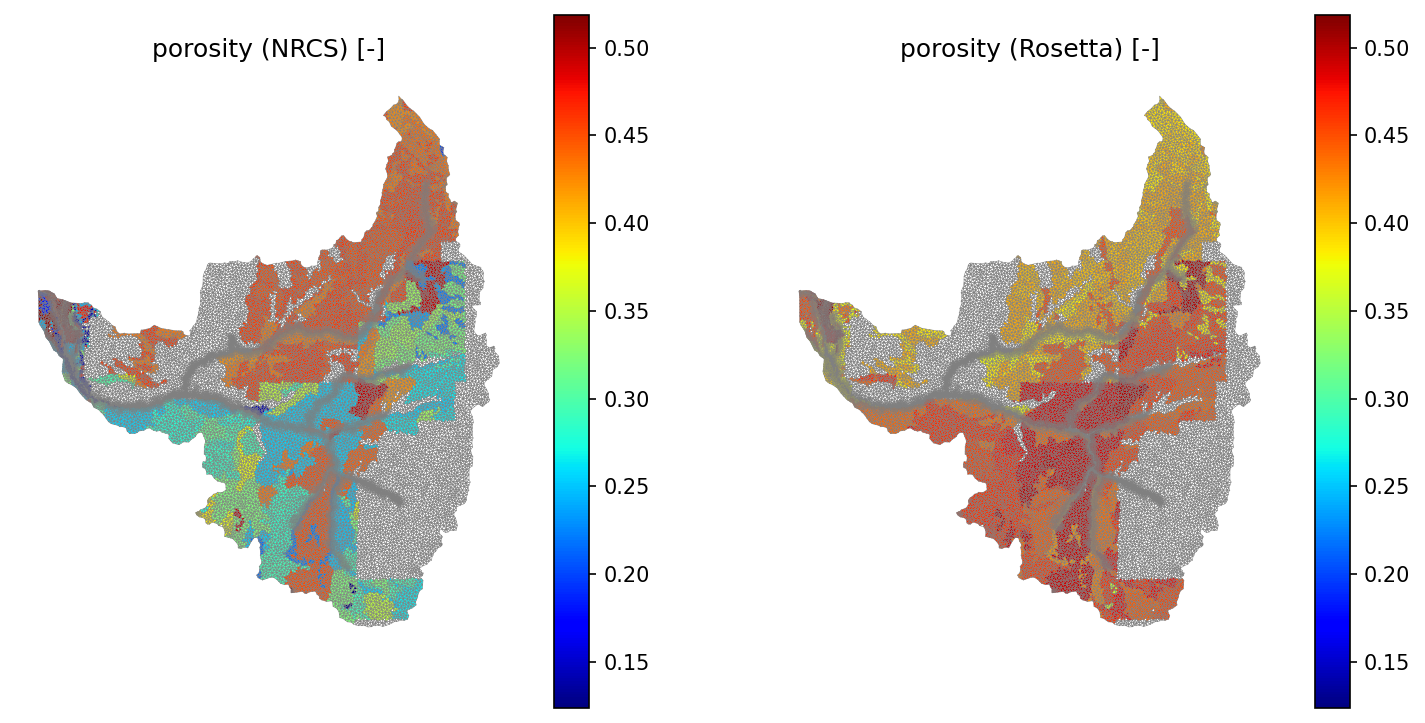

In [52]:
# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)

fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')

/tmp/ipykernel_11223/45597466.py:11: RuntimeWarning: All-NaN axis encountered
  pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta).min()))
/tmp/ipykernel_11223/45597466.py:12: RuntimeWarning: All-NaN axis encountered
  pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta).max()))


min = -13.04514291943306, max = -10.373659632624957


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

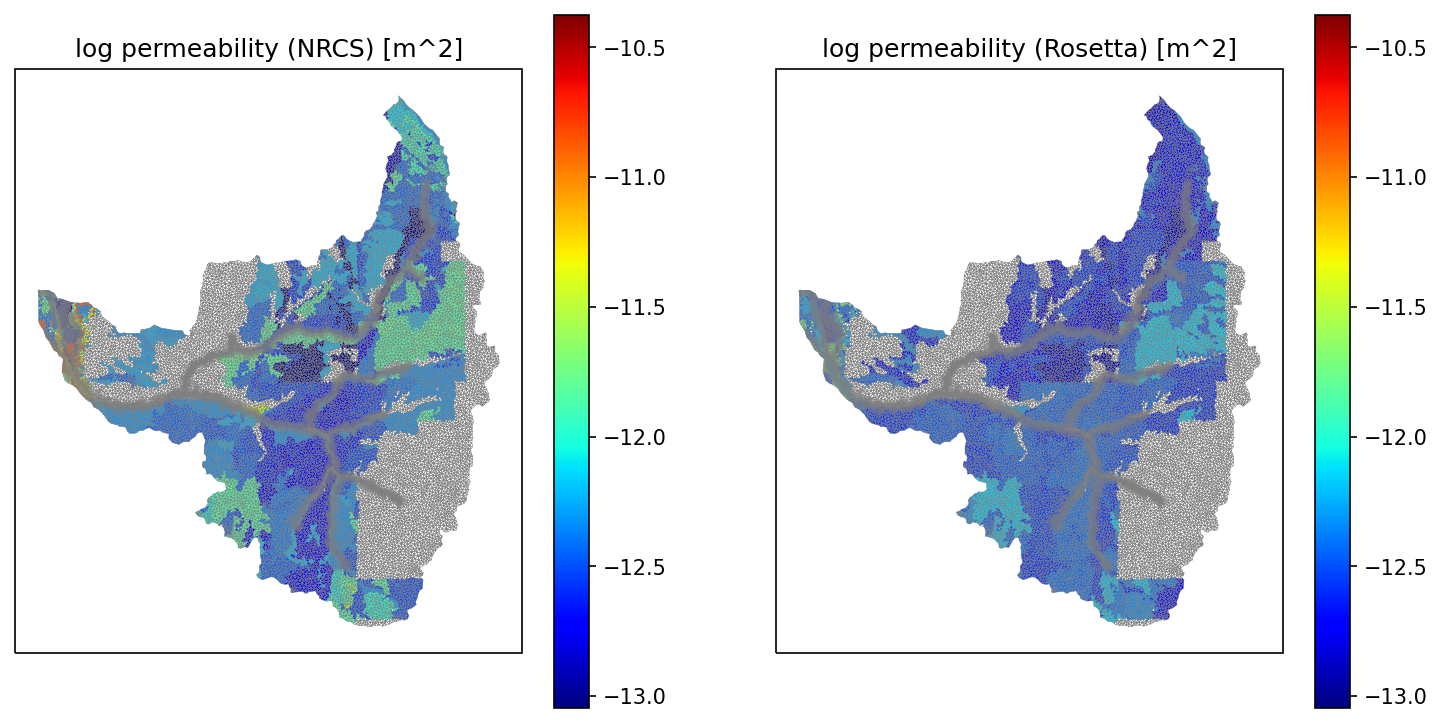

In [53]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta).min()))
pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta).max()))

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




Median soil thickness = 1.52 [m]


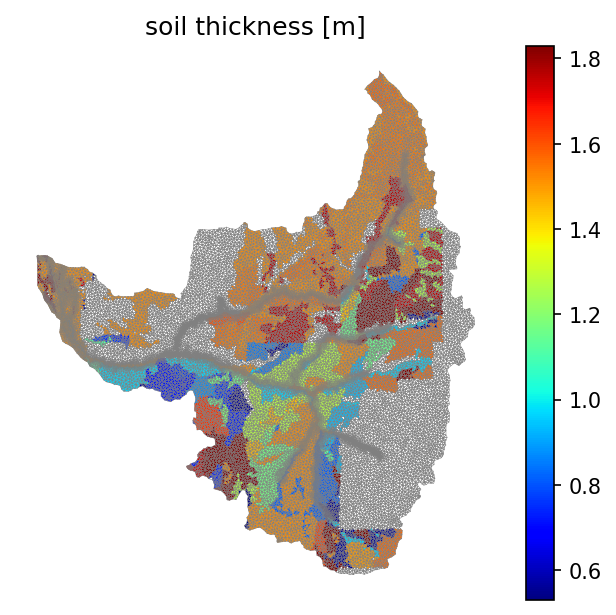

In [54]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

# print(soil_thickness)
soil_thickness = soil_thickness / 100 # convert cm to m
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print(f'Median soil thickness = {np.nanmedian(soil_thickness)} [m]')

In [55]:
def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows, use all cols as duplicate target
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

In [56]:
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

In [57]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
# soil_survey_props_clean = soil_survey_props.copy()
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
# soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)

soil_survey_props_clean

native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0         482654                 0.213599                     0.000046   
1         482655                 0.213599                     0.000046   
2         482656                 0.211122                     0.000048   
3         482657                 0.214024                     0.000046   
4         482659                 0.219843                     0.000045   
..           ...                      ...                          ...   
90        623887                 0.221133                     0.000072   
91        623891                 0.200686                     0.000123   
92        623906                 0.186683                     0.000161   
93        623912                 0.256677                     0.000094   
94       2822436                      NaN                          NaN   

    van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-]  \
0              1.441284       0.560000        2.906677e-13      0.292174   
1              1.441284       0.560000        2.906677e-13      0.292174   
2              1.444267       0.762105        3.702062e-13      0.295844   
3              1.446796       0.719444        3.516589e-13      0.278124   
4              1.430216       0.848000        2.792301e-13      0.353101   
..                  ...            ...                 ...           ...   
90             1.401152       1.520000        1.366375e-13      0.456170   
91             1.401760       1.605294        1.640558e-12      0.423943   
92             1.464676       1.520000        1.245940e-13      0.440352   
93             1.310601       1.520000        1.719068e-13      0.456277   
94                  NaN            NaN                 NaN           NaN   

   source  
0    NRCS  
1    NRCS  
2    NRCS  
3    NRCS  
4    NRCS  
..    ...  
90   NRCS  
91   NRCS  
92   NRCS  
93   NRCS  
94   NRCS  

[95 rows x 8 columns]

In [58]:
# drop nans
# soil id with missing properties will be removed, and the space will be filled by geology from below (see mesh extrusion)!
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

# remove duplicates
reindex_remove_duplicates(soil_survey_props_clean, 'native_index')

# assert soil_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert soil_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
soil_survey_props_clean

native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0     (482814,)                 0.213599                     0.000046   
1     (482816,)                 0.211122                     0.000048   
2     (482815,)                 0.214024                     0.000046   
3     (482839,)                 0.219843                     0.000045   
4     (482840,)                 0.221603                     0.000045   
..          ...                      ...                          ...   
77    (482792,)                 0.227164                     0.000090   
78    (482791,)                 0.221133                     0.000072   
79    (482789,)                 0.200686                     0.000123   
80    (623912,)                 0.186683                     0.000161   
81    (623873,)                 0.256677                     0.000094   

    van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-]  \
0              1.441284       0.560000        2.906677e-13      0.292174   
1              1.444267       0.762105        3.702062e-13      0.295844   
2              1.446796       0.719444        3.516589e-13      0.278124   
3              1.430216       0.848000        2.792301e-13      0.353101   
4              1.426964       0.933333        2.759284e-13      0.371153   
..                  ...            ...                 ...           ...   
77             1.373102       1.520000        2.631801e-13      0.458277   
78             1.401152       1.520000        1.366375e-13      0.456170   
79             1.401760       1.605294        1.640558e-12      0.423943   
80             1.464676       1.520000        1.245940e-13      0.440352   
81             1.310601       1.520000        1.719068e-13      0.456277   

   source  
0    NRCS  
1    NRCS  
2    NRCS  
3    NRCS  
4    NRCS  
..    ...  
77   NRCS  
78   NRCS  
79   NRCS  
80   NRCS  
81   NRCS  

[82 rows x 8 columns]

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ff136d35f90>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff136d35ff0>}
setting face color =  [1036 1022   -1 ... 1074 1066 1066]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

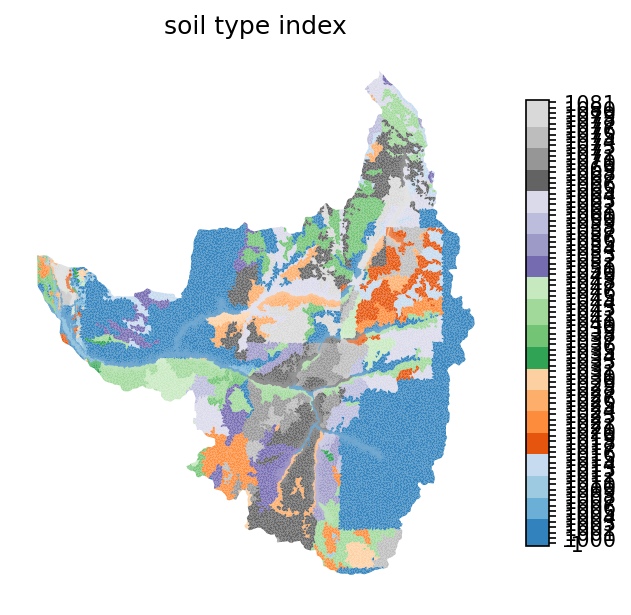

In [59]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukeys in enumerate(soil_survey_props_clean['native_index']):
    for mukey in mukeys:
        soil_color_new[np.where(soil_color == mukey)] = 1000+new_id

# # make sure no -1 in soil ids
# assert -1 not in np.unique(soil_color_new)
        
# image the new soil_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLHYMPS geologic layer

A copy of GLHYMPS v2 geologic shapefile has to be manually downloaded before running the following scripts (see source section for download instructions).

This will get properties (i.e., permeability and porosity) for each geologic layer. In case of missing data, default values of permeability (inf?) and porosity (0.01) will be used. Default van Genuchten alpha, n, and residual saturation are used due to lack of soil/silt/clay pct information. <span style="color:blue;"> </span>

In [60]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2023-10-06 22:00:44,252 - root - INFO: target bounds: (429015.46196265286, 4589994.871362145, 466557.289606457, 4633218.102138742)
2023-10-06 22:00:44,255 - root - INFO: 
2023-10-06 22:00:44,258 - root - INFO: Loading shapes
2023-10-06 22:00:44,261 - root - INFO: ------------------------------
2023-10-06 22:00:44,265 - root - INFO: Getting shapes of GLHYMPS on bounds: (429015.46196265286, 4589994.871362145, 466557.289606457, 4633218.102138742)
2023-10-06 22:00:45,796 - root - INFO: ... found 210 shapes
2023-10-06 22:00:45,798 - root - INFO: Converting to shapely
2023-10-06 22:00:45,880 - root - INFO: Converting to requested CRS
2023-10-06 22:00:46,108 - root - INFO: shape union bounds: (420813.3973048774, 4579712.236391933, 470344.3031675609, 4646565.754460975)
2023-10-06 22:00:46,111 - root - INFO: Coloring shapes onto raster:
2023-10-06 22:00:46,251 - root - INFO:   of shape: (4323, 3756)
2023-10-06 22:00:46,254 - root - INFO:   and 210 independent colors


In [61]:
geo_color

array([ 760631., 1792208.,  760941., ...,  760878.,  760878.,  760878.])

In [62]:
geo_color = geo_color.astype(int)
geo_survey_props.set_index('id', inplace=True)
geo_survey_props

source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                   
1792208  GLHYMPS        1.122018e-15            2.55          0.01   
759829   GLHYMPS        3.162278e-13            0.90          0.27   
759854   GLHYMPS        1.584893e-12            1.50          0.06   
759861   GLHYMPS        1.584893e-12            1.50          0.06   
759862   GLHYMPS        1.584893e-12            1.50          0.06   
...          ...                 ...             ...           ...   
761235   GLHYMPS        1.584893e-12            1.50          0.06   
761236   GLHYMPS        1.584893e-12            1.50          0.06   
815249   GLHYMPS        3.019952e-11            1.61          0.01   
815253   GLHYMPS        3.019952e-11            1.61          0.01   
815265   GLHYMPS        3.019952e-11            1.61          0.01   

         van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
id                                                          
1792208                     0.000146                  2.0   
759829                      0.000472                  2.0   
759854                      0.002240                  2.0   
759861                      0.002240                  2.0   
759862                      0.002240                  2.0   
...                              ...                  ...   
761235                      0.002240                  2.0   
761236                      0.002240                  2.0   
815249                      0.023953                  2.0   
815253                      0.023953                  2.0   
815265                      0.023953                  2.0   

         residual saturation [-]  
id                                
1792208                     0.01  
759829                      0.01  
759854                      0.01  
759861                      0.01  
759862                      0.01  
...                          ...  
761235                      0.01  
761236                      0.01  
815249                      0.01  
815253                      0.01  
815265                      0.01  

[210 rows x 7 columns]

In [63]:

geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]
geo_survey_props


source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                   
760168   GLHYMPS        3.162278e-13            0.90          0.27   
760236   GLHYMPS        1.584893e-12            1.50          0.06   
760304   GLHYMPS        1.584893e-12            1.50          0.06   
760404   GLHYMPS        1.584893e-12            1.50          0.06   
760442   GLHYMPS        1.584893e-12            1.50          0.06   
...          ...                 ...             ...           ...   
761168   GLHYMPS        1.584893e-12            1.50          0.06   
761173   GLHYMPS        1.584893e-12            1.50          0.06   
761177   GLHYMPS        1.584893e-12            1.50          0.06   
815253   GLHYMPS        3.019952e-11            1.61          0.01   
1792208  GLHYMPS        1.122018e-15            2.55          0.01   

         van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
id                                                          
760168                      0.000472                  2.0   
760236                      0.002240                  2.0   
760304                      0.002240                  2.0   
760404                      0.002240                  2.0   
760442                      0.002240                  2.0   
...                              ...                  ...   
761168                      0.002240                  2.0   
761173                      0.002240                  2.0   
761177                      0.002240                  2.0   
815253                      0.023953                  2.0   
1792208                     0.000146                  2.0   

         residual saturation [-]  
id                                
760168                      0.01  
760236                      0.01  
760304                      0.01  
760404                      0.01  
760442                      0.01  
...                          ...  
761168                      0.01  
761173                      0.01  
761177                      0.01  
815253                      0.01  
1792208                     0.01  

[85 rows x 7 columns]

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ff14d687670>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff14d687550>}
setting face color =  [ 760631 1792208  760941 ...  760878  760878  760878]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

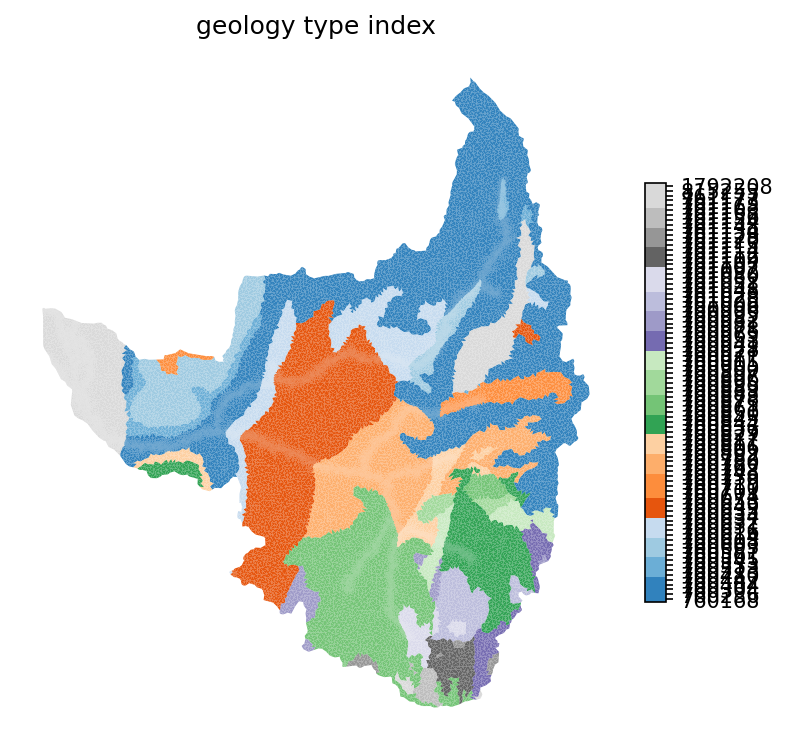

In [64]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20c')


mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('geology type index')
ax.axis('off')




min = -15.2, max = -10.52


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

<Figure size 1800x900 with 0 Axes>

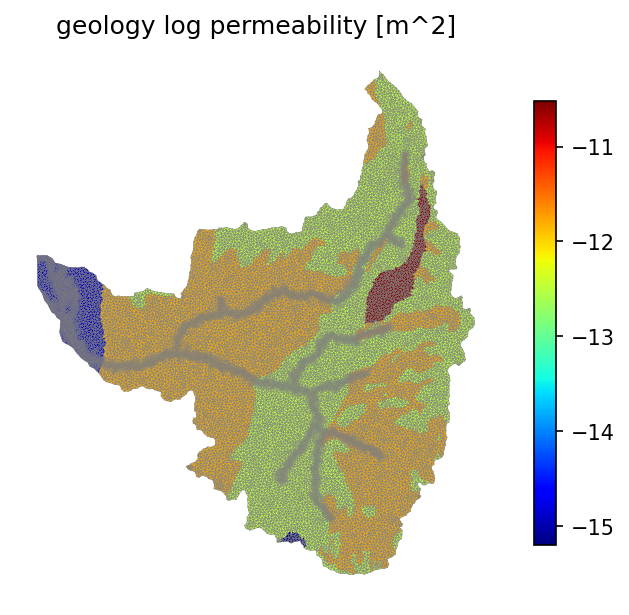

In [65]:
# averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
fig = plt.figure(figsize=(12,6))
geol_perm = np.empty(geo_color.shape, 'd')
# soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for i in geo_survey_props.index:
    geol_perm[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
#     soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(geol_perm)), np.nanmin(np.log10(geol_perm)))
pmax = max(np.nanmax(np.log10(geol_perm)), np.nanmax(np.log10(geol_perm)))

  
print(f'min = {pmin}, max = {pmax}')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(geol_perm), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, shrink=0.8)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')

In [66]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props = geo_survey_props.reset_index()
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)

# remove duplicates
reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
# assert geo_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert geo_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
# assert geo_survey_props_clean['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geo_survey_props_clean

native_index   source  \
0                                          (761134,)  GLHYMPS   
1                                         (1792208,)  GLHYMPS   
2                                          (760533,)  GLHYMPS   
3  (760168, 760603, 760674, 760710, 760743, 76078...  GLHYMPS   
4  (760236, 760304, 760404, 760442, 760480, 76051...  GLHYMPS   
5                                          (815253,)  GLHYMPS   

   permeability [m^2]  porosity [-]  van Genuchten alpha [Pa^-1]  \
0        3.162278e-13          0.27                     0.000472   
1        1.584893e-12          0.06                     0.002240   
2        1.000000e-13          0.22                     0.000294   
3        6.309573e-16          0.19                     0.000025   
4        3.019952e-11          0.01                     0.023953   
5        1.122018e-15          0.01                     0.000146   

   van Genuchten n [-]  residual saturation [-]  
0                  2.0                     0.01  
1                  2.0                     0.01  
2                  2.0                     0.01  
3                  2.0                     0.01  
4                  2.0                     0.01  
5                  2.0                     0.01

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ff14ef38400>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7ff14ef384c0>}
setting face color =  [104 101 104 ... 103 103 103]


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

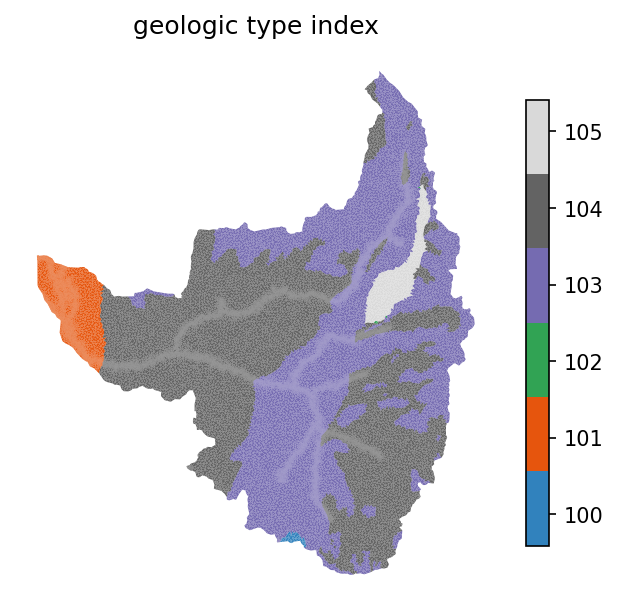

In [67]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+ new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [68]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 watershed.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2023-10-06 22:01:19,975 - root - INFO: 
2023-10-06 22:01:19,976 - root - INFO: Loading Raster
2023-10-06 22:01:19,979 - root - INFO: ------------------------------
2023-10-06 22:01:19,980 - root - INFO: Collecting raster
2023-10-06 22:01:20,009 - root - INFO: bounds in my_crs: (-111.85318349411352, 41.46033044502024, -111.4016450500227, 41.849769913165744)
2023-10-06 22:01:20,085 - root - INFO: ... got raster of shape: (188, 218)
2023-10-06 22:01:20,088 - root - INFO: ... got raster bounds: (-111.85417756999999, 41.851257283, -111.40001097599999, 41.459590679)


(427138.3706, 468434.38139999995, 4587833.70945, 4635379.26355)

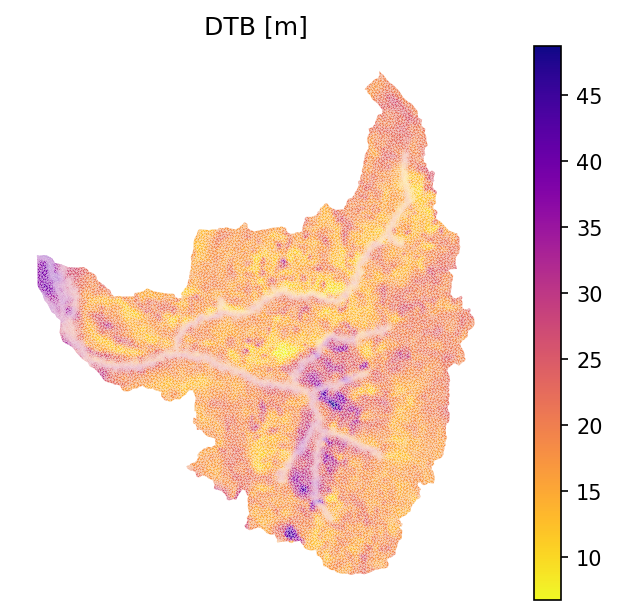

In [69]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')
ax.axis('off')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [70]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

In [71]:
bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()
bedrock_props['source'] = 'SoilGrids'
bedrock_props['native_index'] = '(999,)'

In [72]:
# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])
subsurface_props

native_index     source  \
ats_id                                                                 
100                                             (761134,)    GLHYMPS   
101                                            (1792208,)    GLHYMPS   
102                                             (760533,)    GLHYMPS   
103     (760168, 760603, 760674, 760710, 760743, 76078...    GLHYMPS   
104     (760236, 760304, 760404, 760442, 760480, 76051...    GLHYMPS   
...                                                   ...        ...   
1078                                            (482791,)       NRCS   
1079                                            (482789,)       NRCS   
1080                                            (623912,)       NRCS   
1081                                            (623873,)       NRCS   
999                                                (999,)  SoilGrids   

        permeability [m^2]  porosity [-]  van Genuchten alpha [Pa^-1]  \
ats_id                                                                  
100           3.162278e-13      0.270000                     0.000472   
101           1.584893e-12      0.060000                     0.002240   
102           1.000000e-13      0.220000                     0.000294   
103           6.309573e-16      0.190000                     0.000025   
104           3.019952e-11      0.010000                     0.023953   
...                    ...           ...                          ...   
1078          1.366375e-13      0.456170                     0.000072   
1079          1.640558e-12      0.423943                     0.000123   
1080          1.245940e-13      0.440352                     0.000161   
1081          1.719068e-13      0.456277                     0.000094   
999           1.000000e-16      0.050000                     0.000019   

        van Genuchten n [-]  residual saturation [-]  thickness [m]  
ats_id                                                               
100                2.000000                 0.010000            NaN  
101                2.000000                 0.010000            NaN  
102                2.000000                 0.010000            NaN  
103                2.000000                 0.010000            NaN  
104                2.000000                 0.010000            NaN  
...                     ...                      ...            ...  
1078               1.401152                 0.221133       1.520000  
1079               1.401760                 0.200686       1.605294  
1080               1.464676                 0.186683       1.520000  
1081               1.310601                 0.256677       1.520000  
999                3.000000                 0.010000            NaN  

[89 rows x 8 columns]

In [73]:
# save the properties to disk for use in generating input file
config['subsurface_properties_filename'] = os.path.join('..', '..', 'data', 'examples','BSF', 'processed', 'watershed_subsurface_properties.csv')
subsurface_props.to_csv(config['subsurface_properties_filename'])

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [74]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
total_thickness = np.ceil(DTB.max())
logging.info(f'max DTB: {total_thickness} m')

2023-10-06 22:01:21,620 - root - INFO: max DTB: 49.0 m


In [75]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]


In [76]:
# this looks like it would work out:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]

In [77]:
# a 2 m soil thickness and a maximum of 27 m depth to bedrock suggests a
# geologic layer of 13 * 2 m cells or something finer
dzs_geo = [2.0]*13

In [78]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2023-10-06 22:01:21,883 - root - INFO: Cell summary:
2023-10-06 22:01:21,885 - root - INFO: ------------------------------------------------------------
2023-10-06 22:01:21,887 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2023-10-06 22:01:21,889 - root - INFO: ------------------------------------------------------------
2023-10-06 22:01:21,891 - root - INFO:  00 	| 00 	| 1036 	|   0.050000 	|   0.000000
2023-10-06 22:01:21,894 - root - INFO:  01 	| 01 	| 1036 	|   0.050000 	|   0.050000
2023-10-06 22:01:21,896 - root - INFO:  02 	| 02 	| 1036 	|   0.050000 	|   0.100000
2023-10-06 22:01:21,899 - root - INFO:  03 	| 03 	| 1036 	|   0.120000 	|   0.150000
2023-10-06 22:01:21,902 - root - INFO:  04 	| 04 	| 1036 	|   0.230000 	|   0.270000
2023-10-06 22:01:21,905 - root - INFO:  05 	| 05 	| 1036 	|   0.500000 	|   0.500000
2023-10-06 22:01:21,906 - root - INFO:  06 	| 06 	| 1036 	|   0.500000 	|   1.000000
2023-10-06 22:01:21,907 - root - INFO:  07 	| 07 	|  104 	|   0.500000 	|   1.5

In [79]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [80]:
# # add back on land cover side sets
# surf_ss = m3.side_sets[1]

# for index, name in zip(nlcd_indices, nlcd_labels):
#     where = np.where(lc == index)[0]
#     ss = watershed_workflow.mesh.SideSet(name, int(index), 
#                             [surf_ss.cell_list[w] for w in where],
#                             [surf_ss.side_list[w] for w in where])        
#     m3.side_sets.append(ss)

In [81]:
print(f'total number of cells: {m3.num_cells}')
print('---------------')
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
ls = {}
for i in m3.labeled_sets:
    ls[i.name] = {'setid':i.setid, 'entity':i.entity}
    print(f'{i.setid} : {i.entity} : {len(i.ent_ids)} : "{i.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
ss = {}
for i in m3.side_sets:
    ss[i.name] = {'setid':i.setid}
    print(f'{i.setid} : FACE : {len(i.cell_list)} : "{i.name}"')

total number of cells: 858018
---------------
2D labeled sets
---------------
10000 : CELL : 40858 : "1601020302"
10001 : CELL : 40858 : "1601020302 surface"
10002 : FACE : 746 : "1601020302 boundary"
10003 : FACE : 11 : "1601020302 outlet"
10004 : FACE : 11 : "surface domain outlet"
1 : CELL : 3 : "MODIS Evergreen Needleleaf Forests"
10 : CELL : 40796 : "MODIS Grasslands"
12 : CELL : 59 : "MODIS Croplands"

Extruded 3D labeled sets
------------------------
10000 : CELL : 858018 : "1601020302"

Extruded 3D side sets
---------------------
1 : FACE : 40858 : "bottom"
2 : FACE : 40858 : "surface"
3 : FACE : 15666 : "external_sides"
10001 : FACE : 40858 : "1601020302 surface"
10002 : FACE : 15666 : "1601020302 boundary"
10003 : FACE : 231 : "1601020302 outlet"
10004 : FACE : 231 : "surface domain outlet"
1 : FACE : 3 : "MODIS Evergreen Needleleaf Forests"
10 : FACE : 40796 : "MODIS Grasslands"
12 : FACE : 59 : "MODIS Croplands"


In [82]:
config['labeled_sets'] = ls
config['side_sets'] = ss

### Save mesh file

This will write the 3D mesh to ExodusII using arbitrary polyhedra specification. 

In [83]:
config['mesh_filename'] = os.path.join('..', '..', 'data', 'examples','BSF', 'processed','watershed_mesh.exo')

try:
    os.remove(config['mesh_filename'])
except FileNotFoundError:
    pass
m3.write_exodus(config['mesh_filename'])


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../../data/examples/BSF/processed/watershed_mesh.exo


2023-10-06 22:10:31,176 - root - INFO: adding side set: 1
2023-10-06 22:10:39,174 - root - INFO: adding side set: 2
2023-10-06 22:10:46,023 - root - INFO: adding side set: 3
2023-10-06 22:10:53,218 - root - INFO: adding side set: 10001
2023-10-06 22:11:00,658 - root - INFO: adding side set: 10002
2023-10-06 22:11:08,183 - root - INFO: adding side set: 10003
2023-10-06 22:11:16,080 - root - INFO: adding side set: 10004
2023-10-06 22:11:23,346 - root - INFO: adding side set: 1
2023-10-06 22:11:23,376 - root - INFO: adding side set: 10
2023-10-06 22:11:30,565 - root - INFO: adding side set: 12
2023-10-06 22:11:37,083 - root - INFO: adding elem set: 10000


Closing exodus file: ../../data/examples/BSF/processed/watershed_mesh.exo


In [84]:
config['start_date'] = start_date
config['end_date'] = end_date
config['origin_date'] = origin_date

In [85]:
config

{'catchment_labels': ['1601020302'],
 'nlcd_indices': [1, 10, 12],
 'nlcd_labels': ['MODIS Evergreen Needleleaf Forests',
  'MODIS Grasslands',
  'MODIS Croplands'],
 'LAI_filename': '../../data/examples/BSF/processed/watershed_lai_raw.h5',
 'LAI_typical_filename': '../../data/examples/BSF/processed/watershed_lai_typical.h5',
 'subsurface_properties_filename': '../../data/examples/BSF/processed/watershed_subsurface_properties.csv',
 'labeled_sets': {'1601020302': {'setid': 10000, 'entity': 'CELL'}},
 'side_sets': {'bottom': {'setid': 1},
  'surface': {'setid': 2},
  'external_sides': {'setid': 3},
  '1601020302 surface': {'setid': 10001},
  '1601020302 boundary': {'setid': 10002},
  '1601020302 outlet': {'setid': 10003},
  'surface domain outlet': {'setid': 10004},
  'MODIS Evergreen Needleleaf Forests': {'setid': 1},
  'MODIS Grasslands': {'setid': 10},
  'MODIS Croplands': {'setid': 12}},
 'mesh_filename': '../../data/examples/BSF/processed/watershed_mesh.exo',
 'start_date': '2010-1

In [86]:
# Save dictionary to a file
# config['config_file'] = os.path.join('..', '..', 'data', 'examples','BSF', 'processed','config.yaml')

with open(config_fname, 'w') as file:
    yaml.dump(config, file)